# ============================
# 📦 Imports and Setup
# ============================

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import rasterio
import segmentation_models_pytorch as smp
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.colors as mcolors

# Define device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



c:\Users\devka\anaconda3\envs\nrsc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ============================
# 📁 Directory and File Paths
# ============================

In [2]:
current_dir = r"D:\TestData-Cloud-Shadow"                   #current directory where the input folder is stored
scene_id = "R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1"      #scene id for the folder you want cloud and shadow mask
scene_dir = os.path.join(current_dir, scene_id)
meta_path = os.path.join(scene_dir, "BAND_META.txt")
distance_csv_path = r"D:\NRSC_offline\nrsc\Earth_Sun_distance.xlsx"         #file that contains the distance between earth and sun

npy_output_dir_cloud = os.path.join(current_dir, "npy_outputs_cloud")       #input patches for the cloud model will be stored here in .npy format
segmentation_output_dir_cloud = os.path.join(current_dir, "segmentation_outputs_cloud")     #the cloud mask is stored here in .tif format

npy_output_dir_shadow = os.path.join(current_dir, "npy_outputs_shadow")      #input patches for the shadow model will be stored here in .npy format       
segmentation_output_dir_shadow = os.path.join(current_dir, "segmentation_outputs_shadow")   #the shadow mask is stored here in .tif format

model_path_resunet = r"C:\nrsc_test\resunet_checkpoints\resunet_epoch9.pth"     #path to cloud prediction model
model_path_unet = r"C:\nrsc_test\models_weighted_dropout\shadow_unet_dropout_wce_epoch9.pth"    #path to shadow prediction model

# ============================
# ☀️ TOA Computation for Cloud
# ============================

Takes input all the dn values of the 3 given bands, read the meta file and calculate toa values. Then it stacks those input and store them as .npy files

In [3]:
def compute_toa_to_npy_cloud(scene_id, scene_dir, meta_path, distance_csv_path, Lmin, Lmax, Esun, output_dir, bands):
    os.makedirs(output_dir, exist_ok=True)

    def get_solar_geometry(meta_path, csv_path):
        with open(meta_path, 'r') as f:
            for line in f:
                if 'DateOfPass' in line:
                    date_of_pass = line.split('=')[1].strip()
                elif 'SunElevationAtCenter' in line:
                    sun_elev = float(line.split('=')[1].strip())
        doy = datetime.strptime(date_of_pass, '%d-%b-%Y').timetuple().tm_yday
        df = pd.read_excel(csv_path)
        earth_sun_dist = float(df[df['DOY'] == doy].iloc[0]['d'])
        return sun_elev, earth_sun_dist

    def dn_to_toa(dn, band_name, sun_elev, d):
        radiance = Lmin[band_name] + (dn / 1023.0) * (Lmax[band_name] - Lmin[band_name])
        theta_s_rad = np.deg2rad(90 - sun_elev)
        toa = (np.pi * radiance * d ** 2) / (Esun[band_name] * np.cos(theta_s_rad))
        return np.clip(toa, 0, 1)

    if not os.path.exists(meta_path):
        print(f"[SKIP] Metadata missing at {meta_path}")
        return None

    try:
        sun_elev, earth_sun_dist = get_solar_geometry(meta_path, distance_csv_path)
        toa_arrays = []
        for band in bands:
            band_path = os.path.join(scene_dir, f"{band}.tif")
            if not os.path.exists(band_path):
                print(f"[WARN] Missing {band}.tif for {scene_id}")
                return None

            with rasterio.open(band_path) as src:
                dn = src.read(1).astype(np.float32)
                toa = dn_to_toa(dn, band, sun_elev, earth_sun_dist)
                toa_arrays.append(toa)

        # Stack into (H, W, C) format for model
        stacked_array = np.stack(toa_arrays, axis=0)  # Shape: (C, H, W)
        stacked_array = np.transpose(stacked_array, (1, 2, 0))  # Shape: (H, W, C)

        # Save as .npy
        npy_path = os.path.join(output_dir, f"{scene_id}_input.npy")
        np.save(npy_path, stacked_array)
        print(f"[✅ DONE] Saved TOA .npy to {npy_path}")
        return npy_path

    except Exception as e:
        print(f"[ERROR] {scene_id}: {str(e)}")
        return None


# ============================
# ⚙️ Define Models
# ============================


## Cloud Model

In [4]:
resunet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(device)


## Shadow Model


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=5, n_classes=2, dropout=0.2):
        super().__init__()
        self.down1 = DoubleConv(n_channels, 64, dropout)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128, dropout)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256, dropout)
        self.pool3 = nn.MaxPool2d(2)
        self.middle = DoubleConv(256, 512, dropout)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256, dropout)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128, dropout)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64, dropout)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        mid = self.middle(self.pool3(d3))
        u3 = self.up3(mid)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)
        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)
        return self.out(u1)

# ============================
# 🧩 Chunk Dataset
# ============================

Takes in input folder of any size and divide them into 128x128 patches

In [6]:
class ChunkImageDataset(Dataset):
    def __init__(self, npy_path, chunk_size=1024, patch_size=128):
        self.npy_path = npy_path
        self.chunk_size = chunk_size
        self.patch_size = patch_size
        # Get image dimensions without loading full array
        data = np.load(npy_path, mmap_mode='r')
        self.h, self.w, _ = data.shape
        data._mmap.close()  # Manually close the memory-mapped file
        del data  # Ensure the reference is removed
        self.chunks = []

        # Create chunks with overlap to avoid seams
        overlap = patch_size // 2  # Overlap to ensure smooth stitching
        for i in range(0, self.h, chunk_size - overlap):
            for j in range(0, self.w, chunk_size - overlap):
                h_start = i
                w_start = j
                h_end = min(i + chunk_size, self.h)
                w_end = min(j + chunk_size, self.w)
                self.chunks.append((h_start, w_start, h_end, w_end))

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        h_start, w_start, h_end, w_end = self.chunks[idx]
        # Load only the required chunk
        data = np.load(self.npy_path, mmap_mode='r')
        chunk = data[h_start:h_end, w_start:w_end, :].astype(np.float32)
        data._mmap.close()  # Manually close the memory-mapped file
        del data  # Ensure the reference is removed

        # Pad chunk if necessary
        if chunk.shape[0] < self.patch_size or chunk.shape[1] < self.patch_size:
            pad_h = max(self.patch_size - chunk.shape[0], 0)
            pad_w = max(self.patch_size - chunk.shape[1], 0)
            chunk = np.pad(chunk, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')

        # Create patches within chunk
        patches = []
        patch_coords = []
        for i in range(0, chunk.shape[0], self.patch_size):
            for j in range(0, chunk.shape[1], self.patch_size):
                h_end_patch = min(i + self.patch_size, chunk.shape[0])
                w_end_patch = min(j + self.patch_size, chunk.shape[1])
                patch = chunk[i:h_end_patch, j:w_end_patch, :]
                if patch.shape[0] < self.patch_size or patch.shape[1] < self.patch_size:
                    pad_h = self.patch_size - patch.shape[0]
                    pad_w = self.patch_size - patch.shape[1]
                    patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
                patches.append(patch.transpose(2, 0, 1))  # Shape: (C, H, W)
                patch_coords.append([i, j, h_end_patch - i, w_end_patch - j])  # Store as list

        return (torch.tensor(np.stack(patches), dtype=torch.float32),
                patch_coords,  # Keep as list to avoid tensor conversion
                h_start,
                w_start,
                h_end - h_start,
                w_end - w_start)

# ============================
# ☁️ Cloud Segmentation Function
# ============================

Segments the predicted cloud masks together in the same format(hxw) as the input

In [7]:
def perform_segmentation_cloud(model, scene_id, npy_path, model_path, output_dir, ref_tif_path, patch_size=128, chunk_size=1024):
    os.makedirs(output_dir, exist_ok=True)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Get original image dimensions
    data = np.load(npy_path, mmap_mode='r')
    h, w, _ = data.shape
    data._mmap.close()
    del data

    # Initialize output mask and count for blending
    output_mask = np.zeros((h, w), dtype=np.float32)  # Use float for accumulation
    count_mask = np.zeros((h, w), dtype=np.float32)   # Track contributions for averaging

    # Load dataset
    dataset = ChunkImageDataset(npy_path, chunk_size=chunk_size, patch_size=patch_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    # Inference
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="🔍 Segmenting chunks"):
            patches, patch_coords, h_start, w_start, h_size, w_size = batch
            patches = patches[0].to(device)  # Shape: (n_patches, C, H, W)
            outputs = model(patches)  # Shape: (n_patches, n_classes, patch_size, patch_size)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (n_patches, patch_size, patch_size)

            # Initialize chunk mask
            chunk_mask = np.zeros((h_size.item(), w_size.item()), dtype=np.float32)
            chunk_count = np.zeros((h_size.item(), w_size.item()), dtype=np.float32)

            # Place patches in chunk
            for pred, coord in zip(preds, patch_coords):
                i, j, h_patch, w_patch = coord

                end_i = min(i + h_patch, chunk_mask.shape[0])
                end_j = min(j + w_patch, chunk_mask.shape[1])
                patch_h = end_i - i
                patch_w = end_j - j

                pred_crop = pred[:patch_h, :patch_w].astype(np.float32)
                chunk_mask[i:end_i, j:end_j] += pred_crop
                chunk_count[i:end_i, j:end_j] += 1
            # Average overlapping patch predictions
            chunk_mask = np.divide(chunk_mask, chunk_count, where=chunk_count > 0).astype(np.uint8)

            # Place chunk in output mask with blending
            h_start, w_start = h_start.item(), w_start.item()
            output_mask[h_start:h_start+h_size, w_start:w_start+w_size] += chunk_mask
            count_mask[h_start:h_start+h_size, w_start:w_start+w_size] += 1

    # Finalize output mask by averaging overlapping chunks
    output_mask = np.divide(output_mask, count_mask, where=count_mask > 0).astype(np.uint8)

    # Save georeferenced TIFF
    output_tif_path = os.path.join(output_dir, f"{scene_id}_cloud_mask.tif")
    global cloud_mask_path
    cloud_mask_path = output_tif_path
    with rasterio.open(ref_tif_path) as ref:
        profile = ref.profile.copy()
        profile.update({
            "dtype": "uint8",
            "count": 1,
            "compress": "lzw"
        })

        with rasterio.open(output_tif_path, "w", **profile) as dst:
            dst.write(output_mask, 1)

    print(f"[✅ DONE] Saved segmentation mask to {output_tif_path}")

# ============================
# 🌑 Shadow TOA Computation
# ============================

Takes input the 3 band values, predicted cloud mask for that particulat patch and sunelevationatcenter as input and stack them over each other and stores them in .npy format

In [8]:
def compute_toa_to_npy_shadow(scene_id, scene_dir, meta_path, distance_csv_path, Lmin, Lmax, Esun, output_dir, bands, cloud_mask_path=None):
    os.makedirs(output_dir, exist_ok=True)

    def get_solar_geometry(meta_path, csv_path):
        with open(meta_path, 'r') as f:
            for line in f:
                if 'DateOfPass' in line:
                    date_of_pass = line.split('=')[1].strip()
                elif 'SunElevationAtCenter' in line:
                    sun_elev = float(line.split('=')[1].strip())
        doy = datetime.strptime(date_of_pass, '%d-%b-%Y').timetuple().tm_yday
        df = pd.read_excel(csv_path)
        earth_sun_dist = float(df[df['DOY'] == doy].iloc[0]['d'])
        return sun_elev, earth_sun_dist

    def dn_to_toa(dn, band_name, sun_elev, d):
        radiance = Lmin[band_name] + (dn / 1023.0) * (Lmax[band_name] - Lmin[band_name])
        theta_s_rad = np.deg2rad(90 - sun_elev)
        toa = (np.pi * radiance * d ** 2) / (Esun[band_name] * np.cos(theta_s_rad))
        return np.clip(toa, 0, 1)

    try:
        sun_elev, earth_sun_dist = get_solar_geometry(meta_path, distance_csv_path)

        toa_arrays = []
        for band in bands:
            band_path = os.path.join(scene_dir, f"{band}.tif")
            if not os.path.exists(band_path):
                print(f"[WARN] Missing {band}.tif for {scene_id}")
                return None
            with rasterio.open(band_path) as src:
                dn = src.read(1).astype(np.float32)
                toa = dn_to_toa(dn, band, sun_elev, earth_sun_dist)
                toa_arrays.append(toa)

        # Add cloud mask (optional)
        if cloud_mask_path is not None:
            with rasterio.open(cloud_mask_path) as src:
                cloud_mask = src.read(1).astype(np.float32)
                cloud_mask = np.clip(cloud_mask, 0, 1)  # Just in case
                toa_arrays.append(cloud_mask)

        # Add sun elevation (same shape as bands)
        sun_elev_channel = np.full_like(toa_arrays[0], fill_value=sun_elev / 90.0)  # Normalize to 0–1
        toa_arrays.append(sun_elev_channel)

        # Stack all channels into (H, W, C)
        stacked_array = np.stack(toa_arrays, axis=0)  # (C, H, W)
        stacked_array = np.transpose(stacked_array, (1, 2, 0))  # (H, W, C)

        npy_path = os.path.join(output_dir, f"{scene_id}_input.npy")
        np.save(npy_path, stacked_array)
        print(f"[✅ DONE] Saved TOA + cloud + sun elevation .npy to {npy_path}")
        return npy_path

    except Exception as e:
        print(f"[ERROR] {scene_id}: {str(e)}")
        return None

# ============================
# 🌑 Shadow Segmentation Function
# ============================

Segments the shadow patches together and store them in .tif format

In [9]:
def perform_segmentation_shadow(scene_id, npy_path, model_path, output_dir, ref_tif_path, patch_size=128, chunk_size=1024):
    os.makedirs(output_dir, exist_ok=True)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=5, n_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Get original image dimensions
    data = np.load(npy_path, mmap_mode='r')
    h, w, _ = data.shape
    data._mmap.close()
    del data

    # Initialize output mask and count for blending
    output_mask = np.zeros((h, w), dtype=np.float32)  # Use float for accumulation
    count_mask = np.zeros((h, w), dtype=np.float32)   # Track contributions for averaging

    # Load dataset
    dataset = ChunkImageDataset(npy_path, chunk_size=chunk_size, patch_size=patch_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    # Inference
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="🔍 Segmenting chunks"):
            patches, patch_coords, h_start, w_start, h_size, w_size = batch
            patches = patches[0].to(device)  # Shape: (n_patches, C, H, W)
            outputs = model(patches)  # Shape: (n_patches, n_classes, patch_size, patch_size)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (n_patches, patch_size, patch_size)

            # Initialize chunk mask
            chunk_mask = np.zeros((h_size.item(), w_size.item()), dtype=np.float32)
            chunk_count = np.zeros((h_size.item(), w_size.item()), dtype=np.float32)

            # Place patches in chunk
            for pred, coord in zip(preds, patch_coords):
                i, j, h_patch, w_patch = coord

                end_i = min(i + h_patch, chunk_mask.shape[0])
                end_j = min(j + w_patch, chunk_mask.shape[1])
                patch_h = end_i - i
                patch_w = end_j - j

                pred_crop = pred[:patch_h, :patch_w].astype(np.float32)
                chunk_mask[i:end_i, j:end_j] += pred_crop
                chunk_count[i:end_i, j:end_j] += 1

            # Average overlapping patch predictions
            chunk_mask = np.divide(chunk_mask, chunk_count, where=chunk_count > 0).astype(np.uint8)

            # Place chunk in output mask with blending
            h_start, w_start = h_start.item(), w_start.item()
            output_mask[h_start:h_start+h_size, w_start:w_start+w_size] += chunk_mask
            count_mask[h_start:h_start+h_size, w_start:w_start+w_size] += 1

    # Finalize output mask by averaging overlapping chunks
    output_mask = np.divide(output_mask, count_mask, where=count_mask > 0).astype(np.uint8)

    # Save georeferenced TIFF
    output_tif_path = os.path.join(output_dir, f"{scene_id}_shadow_mask.tif")
    with rasterio.open(ref_tif_path) as ref:
        profile = ref.profile.copy()
        profile.update({
            "dtype": "uint8",
            "count": 1,
            "compress": "lzw"
        })

        with rasterio.open(output_tif_path, "w", **profile) as dst:
            dst.write(output_mask, 1)

    print(f"[✅ DONE] Saved segmentation mask to {output_tif_path}")

# ============================
# ▶️ Run Cloud Segmentation
# ============================

Function calling in proper order for cloud prediction

In [10]:
npy_path = compute_toa_to_npy_cloud(
    scene_id=scene_id,
    scene_dir=scene_dir,
    meta_path=meta_path,
    distance_csv_path=distance_csv_path,
    Lmin={"BAND2": 0.0, "BAND3": 0.0, "BAND4": 0.0},
    Lmax={"BAND2": 52.0, "BAND3": 47.0, "BAND4": 31.5},
    Esun={"BAND2": 185.347, "BAND3": 158.262, "BAND4": 110.81},
    output_dir=npy_output_dir_cloud,
    bands=["BAND2", "BAND3", "BAND4"]
)
if npy_path is None:
    print("[ERROR] Failed to generate .npy file. Exiting.")
    exit()

resunet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

perform_segmentation_cloud(
    model=resunet_model,
    scene_id=scene_id,
    npy_path=npy_path,
    model_path=model_path_resunet,
    output_dir=segmentation_output_dir_cloud,
    ref_tif_path=os.path.join(scene_dir, "BAND2.tif"),
    patch_size=128,
    chunk_size=1024
)

[✅ DONE] Saved TOA .npy to D:\TestData-Cloud-Shadow\npy_outputs_cloud\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1_input.npy


C:\Users\devka\AppData\Local\Temp\ipykernel_19424\1644863743.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

[✅ DONE] Saved segmentation mask to D:\TestData-Cloud-Shadow\segmentation_outputs_cloud\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1_cloud_mask.tif


# ============================
# 📊 Visualize Cloud Output
# ============================

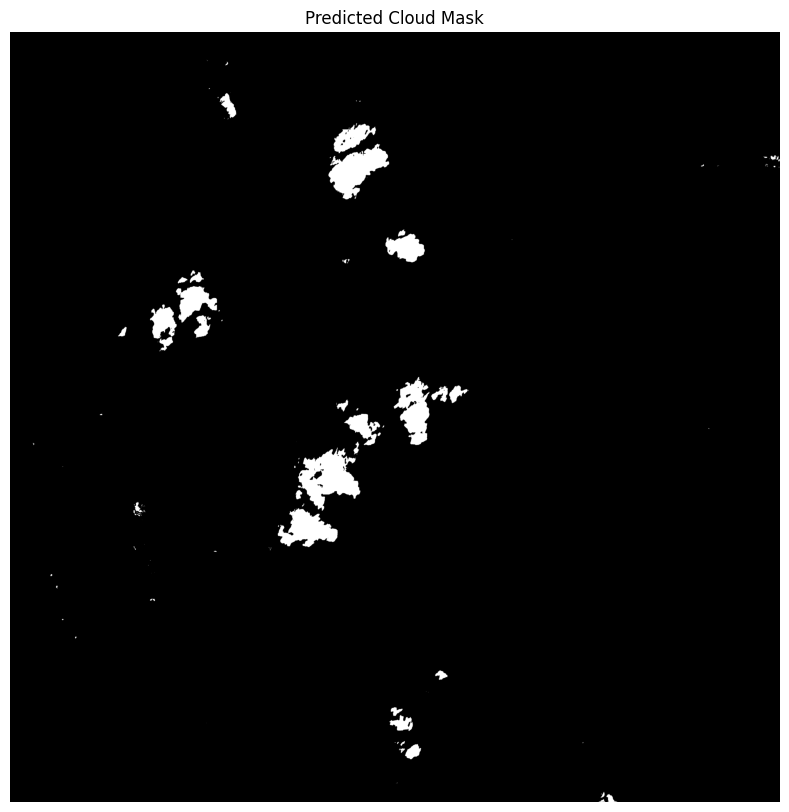

In [11]:
with rasterio.open(os.path.join(segmentation_output_dir_cloud, f"{scene_id}_cloud_mask.tif")) as src:
    mask = src.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap="gray")
plt.title("Predicted Cloud Mask")
plt.axis("off")
plt.show()

# ============================
# ▶️ Run Shadow Segmentation
# ============================

Function calling in proper order for shadow prediction

In [12]:
npy_path = compute_toa_to_npy_shadow(
    scene_id=scene_id,
    scene_dir=scene_dir,
    meta_path=meta_path,
    distance_csv_path=distance_csv_path,
    Lmin={"BAND2": 0.0, "BAND3": 0.0, "BAND4": 0.0},
    Lmax={"BAND2": 52.0, "BAND3": 47.0, "BAND4": 31.5},
    Esun={"BAND2": 185.347, "BAND3": 158.262, "BAND4": 110.81},
    output_dir=npy_output_dir_shadow,
    bands=["BAND2", "BAND3", "BAND4"],
    cloud_mask_path=os.path.join(segmentation_output_dir_cloud, f"{scene_id}_cloud_mask.tif")
)

if npy_path is None:
    print("[ERROR] Failed to generate .npy file. Exiting.")
    exit()

perform_segmentation_shadow(
    scene_id=scene_id,
    npy_path=npy_path,
    model_path=model_path_unet,
    output_dir=segmentation_output_dir_shadow,
    ref_tif_path=os.path.join(scene_dir, "BAND2.tif"),
    patch_size=128,
    chunk_size=1024
)

C:\Users\devka\AppData\Local\Temp\ipykernel_19424\3212950069.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

[✅ DONE] Saved TOA + cloud + sun elevation .npy to D:\TestData-Cloud-Shadow\npy_outputs_shadow\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1_input.npy


🔍 Segmenting chunks: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


[✅ DONE] Saved segmentation mask to D:\TestData-Cloud-Shadow\segmentation_outputs_shadow\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1_shadow_mask.tif


# ============================
# 📊 Visualize Shadow Output
# ============================

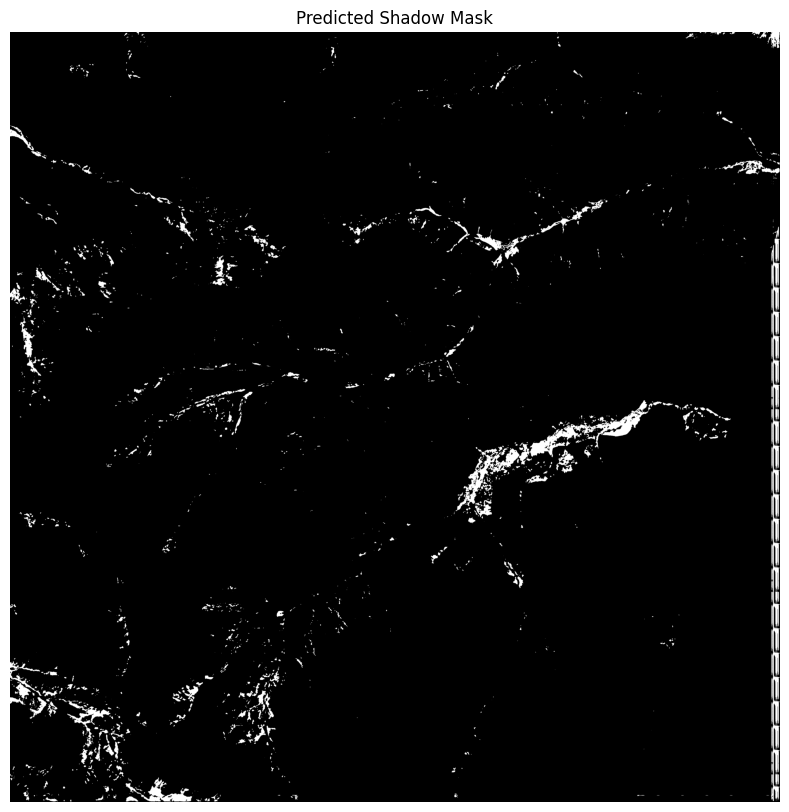

In [13]:
with rasterio.open(os.path.join(segmentation_output_dir_shadow, f"{scene_id}_shadow_mask.tif")) as src:
    mask = src.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap="gray")
plt.title("Predicted Shadow Mask")
plt.axis("off")
plt.show()


# ============================
# 🔄 Merge Cloud and Shadow Masks
# ============================

Merging the cloud and shadow mask in proper format<br>
1-> cloud<br>
2-> shadow<br>
0-> everything else

In [14]:
cloud_mask_path = os.path.join(segmentation_output_dir_cloud, f"{scene_id}_cloud_mask.tif")
shadow_mask_path = os.path.join(segmentation_output_dir_shadow, f"{scene_id}_shadow_mask.tif")
merged_mask_path = os.path.join(current_dir, f"{scene_id}_merged_shadow_cloud.tif")

with rasterio.open(cloud_mask_path) as cloud_src, rasterio.open(shadow_mask_path) as shadow_src:
    cloud_mask = cloud_src.read(1)
    shadow_mask = shadow_src.read(1)
    profile = cloud_src.profile.copy()

    # Initialize merged mask
    merged_mask = np.zeros_like(cloud_mask, dtype=np.uint8)

    # Assign cloud (1) wherever cloud_mask is 1
    merged_mask[cloud_mask == 1] = 1

    # Assign shadow (2) wherever shadow == 1 AND cloud != 1
    merged_mask[(shadow_mask == 1) & (cloud_mask != 1)] = 2

    # Save merged mask
    profile.update(dtype="uint8", count=1, compress="lzw")
    with rasterio.open(merged_mask_path, "w", **profile) as dst:
        dst.write(merged_mask, 1)

print(f"[✅ DONE] Saved merged cloud-shadow mask to {merged_mask_path}")

[✅ DONE] Saved merged cloud-shadow mask to D:\TestData-Cloud-Shadow\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1_merged_shadow_cloud.tif


# ============================
# 📊 Visualize Merged Output
# ============================

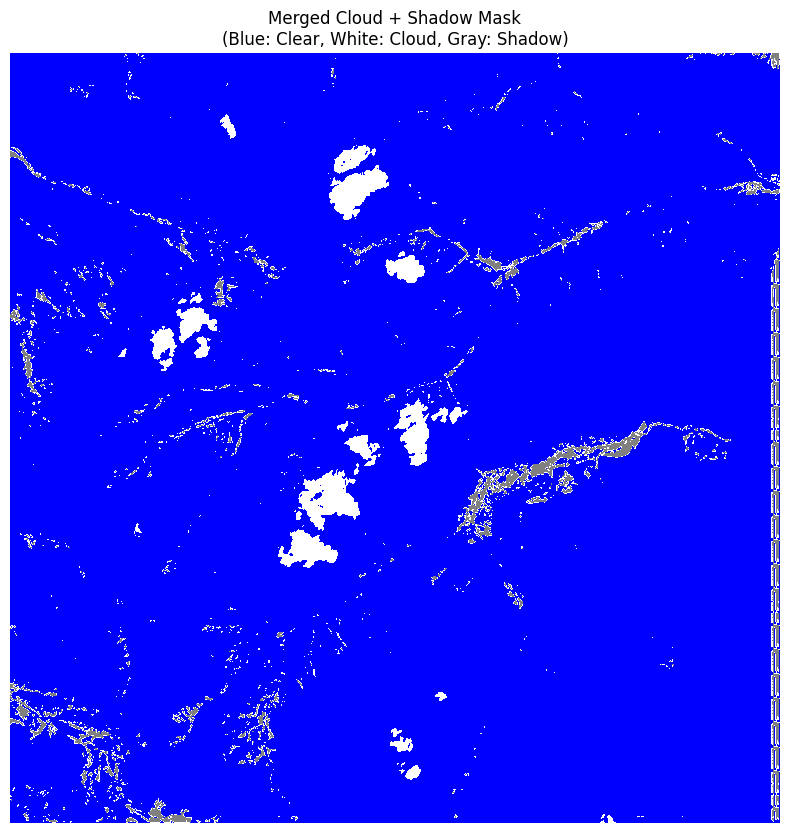

In [15]:
# Path to merged mask
merged_mask_path = os.path.join(current_dir, f"{scene_id}_merged_shadow_cloud.tif")

# Define custom colormap: 0=blue, 1=white, 2=gray
cmap = mcolors.ListedColormap(["blue", "white", "gray"])
bounds = [0, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Read and plot
with rasterio.open(merged_mask_path) as src:
    mask = src.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap=cmap, norm=norm)
plt.title("Merged Cloud + Shadow Mask\n(Blue: Clear, White: Cloud, Gray: Shadow)")
plt.axis("off")
plt.show()


# ============================
# 📊 Converting the cloud tif files into shape files
# ============================

In [16]:
def tif_to_shapefile_cloud(tif_path, shp_basename="cloud_mask"):
    with rasterio.open(tif_path) as src:
        mask = src.read(1)
        transform = src.transform
        crs = src.crs

    binary_mask = (mask == 1).astype('uint8')
    shapes_gen = shapes(binary_mask, mask=binary_mask, transform=transform)
    geoms = [shape(geom) for geom, val in shapes_gen if val == 1]

    gdf = gpd.GeoDataFrame({'geometry': geoms, 'class': ['cloud'] * len(geoms)}, crs=crs)
    
    # Save as .shp (Colab writes 3-5 files for one shapefile)
    output_folder = fr"D:\nrsc_final_submission\{scene_id}shape_files"
    os.makedirs(output_folder, exist_ok=True)
    shp_path = os.path.join(output_folder, shp_basename + ".shp")
    gdf.to_file(shp_path)
    print(f"✅ Shapefile saved at: {shp_path}")
    return output_folder

cloud_mask_path = os.path.join(segmentation_output_dir_cloud, f"{scene_id}_cloud_mask.tif")
# Run this
output_folder = tif_to_shapefile_cloud(cloud_mask_path)  # Replace with your actual filename if different

✅ Shapefile saved at: D:\nrsc_final_submission\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1shape_files\cloud_mask.shp


# ============================
# 📊 Converting the shadow tif files into shape files
# ============================

In [17]:
def tif_to_shapefile_shadow(tif_path, shp_basename="shadow_mask"):
    import rasterio
    from rasterio.features import shapes
    import geopandas as gpd
    from shapely.geometry import shape
    import os

    with rasterio.open(tif_path) as src:
        mask = src.read(1)
        transform = src.transform
        crs = src.crs

    # Shadows are assumed to be labeled as 2
    binary_mask = (mask == 1).astype('uint8')
    shapes_gen = shapes(binary_mask, mask=binary_mask, transform=transform)
    geoms = [shape(geom) for geom, val in shapes_gen if val == 1]

    # Label everything as 'shadow'
    gdf = gpd.GeoDataFrame({'geometry': geoms, 'class': ['shadow'] * len(geoms)}, crs=crs)
    
    output_folder = fr"D:\nrsc_final_submission\{scene_id}shape_files"
    os.makedirs(output_folder, exist_ok=True)
    shp_path = os.path.join(output_folder, shp_basename + ".shp")
    gdf.to_file(shp_path)

    print(f"✅ Shapefile saved at: {shp_path}")
    return output_folder

shadow_mask_path = os.path.join(segmentation_output_dir_shadow, f"{scene_id}_shadow_mask.tif")
output_folder = tif_to_shapefile_shadow(shadow_mask_path)


✅ Shapefile saved at: D:\nrsc_final_submission\R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1shape_files\shadow_mask.shp


# ============================
# 📊 Calculating the %cloud and %shadow pixels
# ============================

In [18]:
def compute_cloud_shadow_percent(mask_tif_path):
    with rasterio.open(mask_tif_path) as src:
        mask = src.read(1)  # Read first (and only) band

    total_pixels = mask.size
    cloud_pixels = np.sum(mask == 1)
    shadow_pixels = np.sum(mask == 2)

    cloud_percent = (cloud_pixels / total_pixels) * 100
    shadow_percent = (shadow_pixels / total_pixels) * 100

    print(f"☁️ Cloud pixels: {cloud_pixels} ({cloud_percent:.2f}%)")
    print(f"🌑 Shadow pixels: {shadow_pixels} ({shadow_percent:.2f}%)")
    return cloud_percent, shadow_percent

merged_mask_path = os.path.join(current_dir, f"{scene_id}_merged_shadow_cloud.tif")


compute_cloud_shadow_percent(merged_mask_path)


☁️ Cloud pixels: 312637 (1.91%)
🌑 Shadow pixels: 383054 (2.34%)


(np.float64(1.9074453068488095), np.float64(2.337070003133551))

# ============================
# 📊 Visualizing the shape file for the cloud mask
# ============================

c:\Users\devka\anaconda3\envs\nrsc\lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1shape_files': 'cloud_mask' (default), 'shadow_mask'. Specify layer parameter to avoid this warning.
  result = read_func(


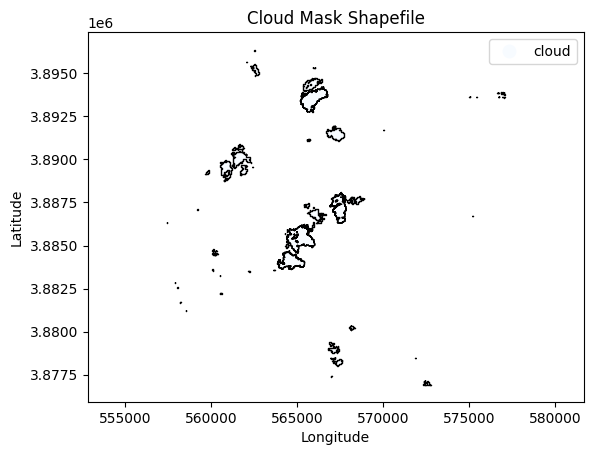

In [19]:
# Path to the saved shapefile
shapefile_path = fr"D:\nrsc_final_submission\{scene_id}shape_files"

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
gdf.plot(column='class', cmap='Blues', edgecolor='black', legend=True)

# Improve layout
plt.title("Cloud Mask Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")  # Keep aspect ratio correct
plt.show()


# ============================
# 📊 Visualizing the shape file for shadow mask
# ============================

c:\Users\devka\anaconda3\envs\nrsc\lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'R2F06SEP2021053879009200045SSANSTUC00GTDD_subset1shape_files': 'cloud_mask' (default), 'shadow_mask'. Specify layer parameter to avoid this warning.
  result = read_func(


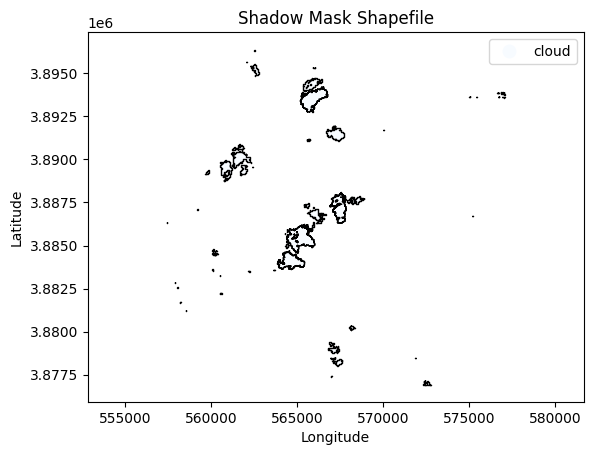

In [20]:
# Path to the saved shapefile
shapefile_path = fr"D:\nrsc_final_submission\{scene_id}shape_files"

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
gdf.plot(column='class', cmap='Blues', edgecolor='black', legend=True)

# Improve layout
plt.title("Shadow Mask Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")  # Keep aspect ratio correct
plt.show()
